# Natural Language Processing with Disaster Tweets

## About Data
data from https://www.kaggle.com/competitions/nlp-getting-started/data

## 定義問題
* 這個問題是如何產生的？這個問題的預期產出是什麼？判斷推文是否為災難推文
* 它提供了哪些資訊、資料與變數？關鍵字 / 推文內容

## 選擇什麼方法？
* 是監督還是非監督學習？監督式學習
* 是分類還是回歸？分類問題

In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.15.0
KerasNLP version: 0.7.0


In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print("Train Shape:", df_train.shape)
print("Test Shape:", df_test.shape)

Train Shape: (7613, 5)
Test Shape: (3263, 4)


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print("-----------------")
print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64
-----------------
Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [7]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 10
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

# Model 選擇
https://keras.io/api/keras_nlp/models/

### 1. BERT
### 2. DistilBERT
### 3. FNet

## 1. BERT

In [9]:
import keras_nlp

# BERT model.
BERT_preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_base_en",
    sequence_length=160, #因為train / test 最長157
    name="preprocessor_4_tweets"
)

# Pretrained classifier.
BERT_classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en",
    preprocessor = BERT_preprocessor,
    num_classes=2
)

BERT_classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              28,996 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 768),   │     108,310,272 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout (Dropout)                             │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 108,311,810 (413.18 MB)

 Trainable params: 108,311,810 (413.18 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
optimizer = Adam(learning_rate = 1e-5)
# Compile
BERT_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)


# Fit
history = BERT_classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
    )

Epoch 1/10
191/191 [==============================] - 274s 1s/step - loss: 0.4803 - accuracy: 0.7803 - val_loss: 0.3894 - val_accuracy: 0.8378
Epoch 2/10
191/191 [==============================] - 219s 1s/step - loss: 0.3614 - accuracy: 0.8468 - val_loss: 0.3946 - val_accuracy: 0.8391
Epoch 3/10
191/191 [==============================] - 216s 1s/step - loss: 0.2882 - accuracy: 0.8885 - val_loss: 0.4324 - val_accuracy: 0.8345
Epoch 4/10
191/191 [==============================] - 248s 1s/step - loss: 0.2238 - accuracy: 0.9220 - val_loss: 0.4692 - val_accuracy: 0.8227
Epoch 5/10
191/191 [==============================] - 219s 1s/step - loss: 0.1830 - accuracy: 0.9355 - val_loss: 0.5361 - val_accuracy: 0.8273
Epoch 6/10
191/191 [==============================] - 216s 1s/step - loss: 0.1431 - accuracy: 0.9517 - val_loss: 0.6034 - val_accuracy: 0.8207
Epoch 7/10
191/191 [==============================] - 248s 1s/step - loss: 0.1116 - accuracy: 0.9621 - val_loss: 0.6741 - val_accuracy: 0.8129

In [11]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 [==============================] - 78s 396ms/step


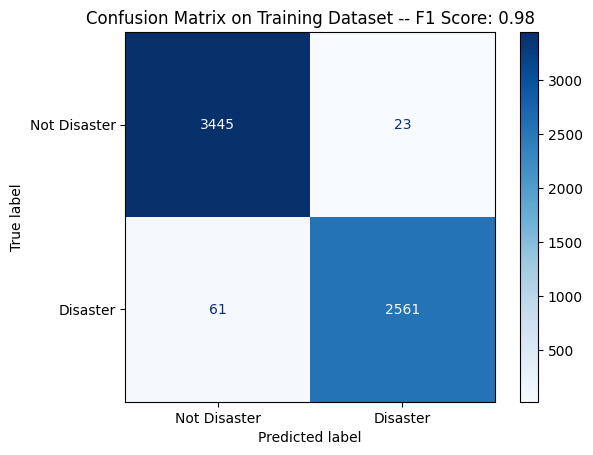

In [12]:
BERT_pred_train = BERT_classifier.predict(X_train)

displayConfusionMatrix(y_train, BERT_pred_train, "Training")

48/48 [==============================] - 19s 390ms/step


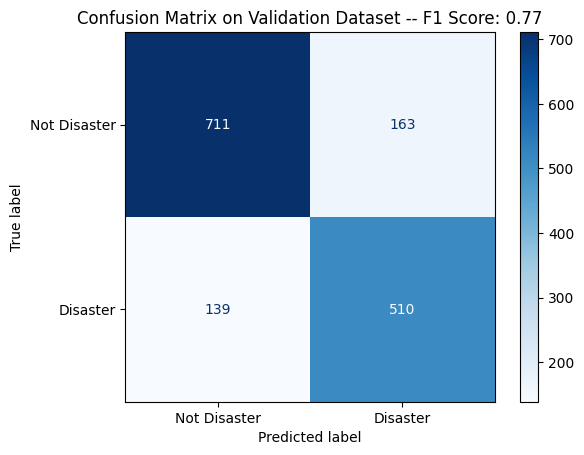

In [13]:
BERT_pred_val = BERT_classifier.predict(X_val)

displayConfusionMatrix(y_val, BERT_pred_val, "Validation")

In [14]:
'''
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()
BERT_sample_submission["target"] = np.argmax(BERT_classifier.predict(X_test), axis=1)
BERT_sample_submission.describe()
BERT_sample_submission.to_csv("submission_bert.csv", index=False)
'''

'\nsample_submission = pd.read_csv("sample_submission.csv")\nsample_submission.head()\nBERT_sample_submission["target"] = np.argmax(BERT_classifier.predict(X_test), axis=1)\nBERT_sample_submission.describe()\nsample_submission.to_csv("submission_bert.csv", index=False)\n'

## 2. DistilBERT

In [15]:
# Use a shorter sequence length.
DistilBERT_preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en",
    sequence_length=160,
    name="preprocessor_4_tweets"
)

# Pretrained classifier.
DistilBERT_classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en",
    preprocessor = DistilBERT_preprocessor,
    num_classes=2
)

DistilBERT_classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              28,996 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      65,190,912 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_1 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 65,783,042 (250.94 MB)

 Trainable params: 65,783,042 (250.94 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
optimizer = Adam(learning_rate = 1e-5)
# Compile
DistilBERT_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)


# Fit
history = DistilBERT_classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

Epoch 1/10
191/191 [==============================] - 129s 576ms/step - loss: 0.5094 - accuracy: 0.7539 - val_loss: 0.4055 - val_accuracy: 0.8280
Epoch 2/10
191/191 [==============================] - 156s 819ms/step - loss: 0.3842 - accuracy: 0.8348 - val_loss: 0.3951 - val_accuracy: 0.8253
Epoch 3/10
191/191 [==============================] - 116s 607ms/step - loss: 0.3255 - accuracy: 0.8686 - val_loss: 0.4073 - val_accuracy: 0.8326
Epoch 4/10
191/191 [==============================] - 109s 571ms/step - loss: 0.2705 - accuracy: 0.8947 - val_loss: 0.4387 - val_accuracy: 0.8332
Epoch 5/10
191/191 [==============================] - 164s 862ms/step - loss: 0.2300 - accuracy: 0.9144 - val_loss: 0.5048 - val_accuracy: 0.8234
Epoch 6/10
191/191 [==============================] - 109s 572ms/step - loss: 0.1973 - accuracy: 0.9286 - val_loss: 0.5411 - val_accuracy: 0.8221
Epoch 7/10
191/191 [==============================] - 110s 575ms/step - loss: 0.1624 - accuracy: 0.9412 - val_loss: 0.5909 -

191/191 [==============================] - 42s 214ms/step


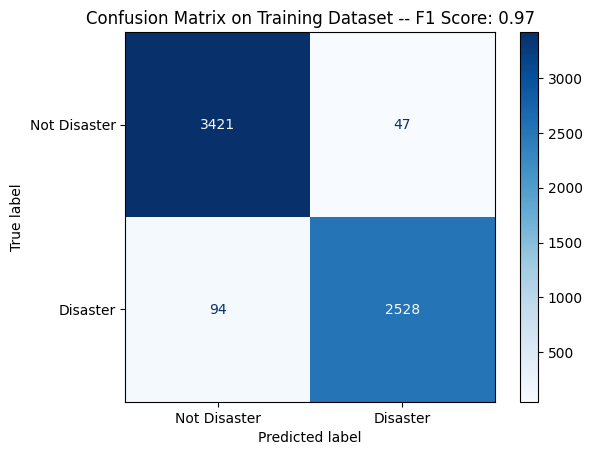

In [17]:
DistilBERT_pred_train = DistilBERT_classifier.predict(X_train)

displayConfusionMatrix(y_train, DistilBERT_pred_train, "Training")

48/48 [==============================] - 10s 187ms/step


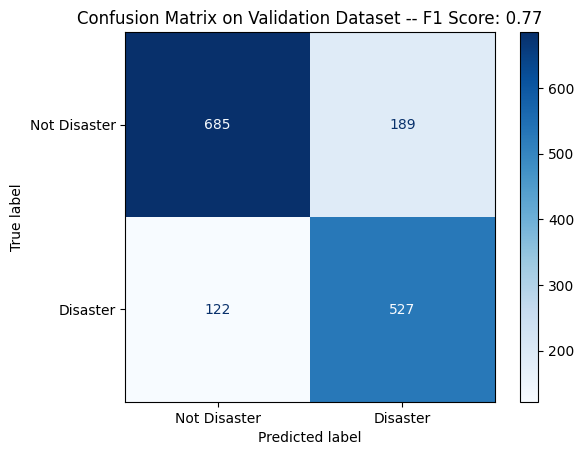

In [18]:
DistilBERT_pred_val = DistilBERT_classifier.predict(X_val)

displayConfusionMatrix(y_val, DistilBERT_pred_val, "Validation")

## 3. FNet

In [19]:
# Use a shorter sequence length.
FNet_preprocessor = keras_nlp.models.FNetPreprocessor.from_preset(
    "f_net_base_en",
    sequence_length=160,
    name="preprocessor_4_tweets"
)

# Pretrained classifier.
FNet_classifier = keras_nlp.models.FNetClassifier.from_preset(
    "f_net_base_en",
    preprocessor = FNet_preprocessor,
    num_classes=2
)

FNet_classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ f_net_tokenizer (FNetTokenizer)                    │                                              32,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "f_net_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ f_net_backbone (FNetBackbone)                 │ {sequence_output: (None, None, 768),   │      82,861,056 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                           │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 82,862,594 (316.10 MB)

 Trainable params: 82,862,594 (316.10 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
optimizer = Adam(learning_rate = 1e-5)
# Compile
FNet_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),# binary_crossentropy
    optimizer=optimizer,
    metrics=["accuracy"]
)


# Fit
history = FNet_classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

Epoch 1/10
191/191 [==============================] - 186s 868ms/step - loss: 0.5607 - accuracy: 0.7167 - val_loss: 0.4412 - val_accuracy: 0.8148
Epoch 2/10
191/191 [==============================] - 170s 892ms/step - loss: 0.4255 - accuracy: 0.8126 - val_loss: 0.4218 - val_accuracy: 0.8181
Epoch 3/10
191/191 [==============================] - 165s 863ms/step - loss: 0.3612 - accuracy: 0.8532 - val_loss: 0.4285 - val_accuracy: 0.8168
Epoch 4/10
191/191 [==============================] - 170s 893ms/step - loss: 0.3025 - accuracy: 0.8818 - val_loss: 0.4560 - val_accuracy: 0.8142
Epoch 5/10
191/191 [==============================] - 165s 863ms/step - loss: 0.2441 - accuracy: 0.9113 - val_loss: 0.5015 - val_accuracy: 0.8122
Epoch 6/10
191/191 [==============================] - 178s 934ms/step - loss: 0.2088 - accuracy: 0.9266 - val_loss: 0.5501 - val_accuracy: 0.8056
Epoch 7/10
191/191 [==============================] - 166s 868ms/step - loss: 0.2000 - accuracy: 0.9255 - val_loss: 0.5646 -

191/191 [==============================] - 53s 269ms/step


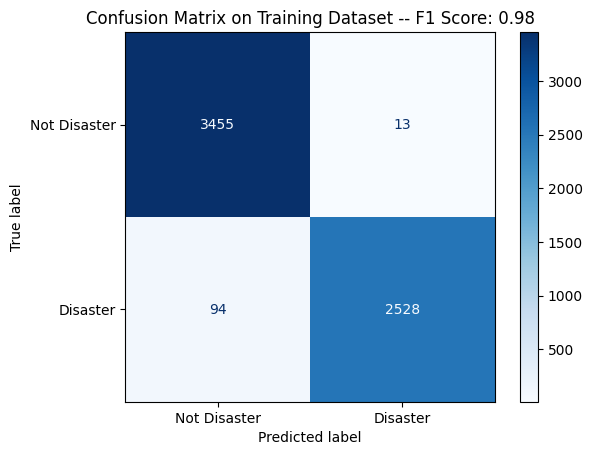

In [21]:
FNet_pred_train = FNet_classifier.predict(X_train)

displayConfusionMatrix(y_train, FNet_pred_train, "Training")

48/48 [==============================] - 13s 259ms/step


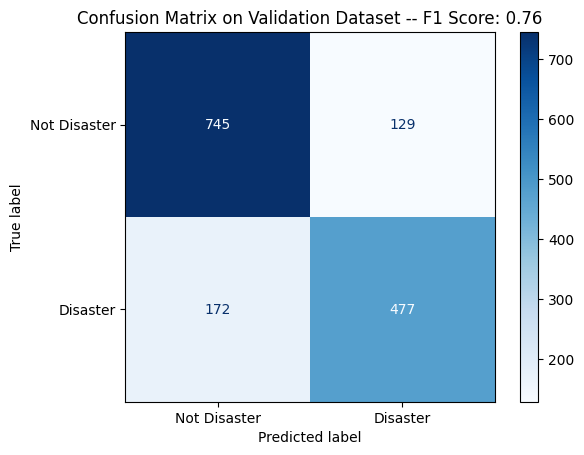

In [22]:
FNet_pred_val = FNet_classifier.predict(X_val)

displayConfusionMatrix(y_val, FNet_pred_val, "Validation")

# 結論
### F1-Score : BERT > FNet > DistilBERT
### Running Time : DistilBERT 最短 BERT 最長